<a href="https://colab.research.google.com/github/samymokhtari/ia-learning/blob/main/Hebb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Premier apprentissage
## 1. Chargement du jeu de données
Jeux de caractères manuscrits proposé par scikitlearn
Représentation des données

Clefs :  ['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR']
Data :  [ 0.  0.  0.  0. 12.  2.  0.  0.  0.  0.  0.  6. 14.  1.  0.  0.  0.  0.
  4. 16.  7.  8.  0.  0.  0.  0. 13.  9.  0. 16.  6.  0.  0.  6. 16. 10.
 11. 16.  0.  0.  0.  0.  5. 10. 13. 16.  0.  0.  0.  0.  0.  0.  6. 16.
  0.  0.  0.  0.  0.  0. 12.  8.  0.  0.]
Annotation : 4


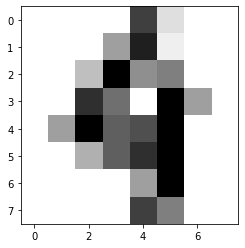

In [1]:
%matplotlib inline

from sklearn.datasets import load_digits
digits = load_digits()

# un index quelconque
idx = 24

# list des clefs du dictionnaire
keyList = list(digits.keys())
print("Clefs : ",keyList)

# représentation d'un élément dans data
print("Data : ", digits.data[idx])

# annotation d'un élément de data
print("Annotation :",digits.target[idx])

import matplotlib.pyplot as plt

plt.imshow(digits.images[idx], cmap='gray_r')
plt.show() 

In [2]:
from sklearn.datasets import get_data_home
print(get_data_home())

/root/scikit_learn_data


## 2. Construction du jeu de données
Définition de la fonction split_train_test, son rôle est de mélanger le jeu de données et de le séparer en deux en fonction d'un ratio (par defaut 0.2 soit 20%). Le ratio exprime la partie réserver pour effectuer les calculs de performances du model.  
Elle prend en paramètre d'entrèe un tableau de vecteurs, où chaque vecteur représente une données et un tableau contenant les classes correspndantes à chaque vecteurs.

[6 9 3 ... 0 7 3]
Taille du jeu du jeu d'apprentissage (1437, 64) et taille du jeux de test (359, 64)

Caractère à la position 24 dans le jeu de données, il est annoté (5)


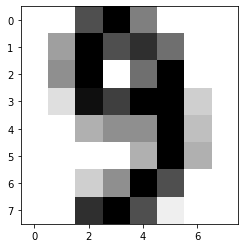

In [3]:
import numpy as np

def split_train_test( data, annotation, ratio=0.2, seed=42 ):
    np.random.seed(seed)
    liste = list(zip(data, annotation))
    np.random.shuffle(liste)
    data, annotation = zip(*liste)
    size_test = int( len(data) * (1-ratio) )
    return np.array(data[:size_test]), np.array(annotation[:size_test]),\
            np.array(data[size_test+1:]), np.array(annotation[size_test+1:])

trainX, trainY, testX, testY = split_train_test( digits.data, digits.target)

print(trainY)

print("Taille du jeu du jeu d'apprentissage {} et taille du jeux de test {}\n".format(trainX.shape, testX.shape))

# exemple du caractère à la position 24
idx = 24
print("Caractère à la position {} dans le jeu de données, il est annoté ({})".format( idx, trainY[idx]))
plt.imshow(trainX[1].reshape(8,8), cmap='gray_r')
plt.show()

## 3. Préparation des données
Les images sont en nuance de gris sur 16 valeurs, les neuronnes de notre modèle sont de type on/off, on va donc devoir convertir nos jeux  
Pour les annotations nous avons 10 classes la classe 0, classe 1 ... classe 9. Pour la même raison que les inputs on va devoir choisir une classe et redéfinir l'annotation à True pour la classe choisi et à False pour toutes les autres.

Caractère à la position 24 dans le jeu de données, il est annoté (False)


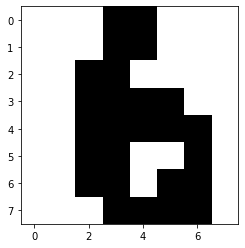

In [4]:
def modif_input( dataset, seuil = 4 ):
    for n in range(len(dataset)):
        for i in range(len(dataset[n])):
             dataset[n][i] = 1 if dataset[n][i] > seuil else 0
    return dataset

trainX = modif_input(trainX)
testX = modif_input(testX)

def modif_output( dataset, classe = 6 ):
    dataset = np.array(list(map( lambda x: x==classe, dataset )))
    return dataset

trainY = modif_output(trainY)
testY = modif_output(testY)

# exemple du caractère à la position 24
idx = 24
print("Caractère à la position {} dans le jeu de données, il est annoté ({})".format( idx, trainY[idx]))
plt.imshow(trainX[0].reshape(8,8), cmap='gray_r')
plt.show()

## 4. Modèle d'apprentissage basé sur HEBB
Fonction fit pour l'apprentissage par renforcement des poids, apprentissage binaire, appartient à une classe ou n'appartient pas, retour le tableau des poids du model.  
Fonction predict pour classer un tableau de vecteur donné.

In [6]:
import numpy as np

# apprentissage
def fit( X, Y ):
    weight = np.array([], float)
    # initialisation des poids
    for i in range(len(X[0])):
        weight = np.append( weight, 1 )
        
    # pour chaque vecteur du jeu de données
    for n in range(len(X)):
        for i in range(len(X[n])):
            weight[i] = weight[i] + X[n][i]*Y[n]
        
    return weight

# classification
def predict( X, weight, seuil = 2000 ):
    Y = []
    for n in range(len(X)):
        w = 0
        for i in range(len(X[n])):
            w = w + X[n][i]*weight[i]
        Y.append( w > seuil)
    return Y

## 5. Mesure de performance
Fonction calculant la précision et le rappel
Fonction calculant la moyenne harmonique de la précision et du rappel

In [7]:
from collections import Counter
    
def performance( test, predic ):
    couple = list(zip(test,predic))
    nbrCouple = Counter(couple)
    TruePositif = nbrCouple[(True,True)]
    FalsePositif = nbrCouple[(False,True)]
    TrueNegatif = nbrCouple[(False,False)]
    FalseNegatif = nbrCouple[(True,False)]
    preci = (TruePositif/(TruePositif+FalsePositif)) if ((TruePositif+FalsePositif)>0) else 0
    rappel = (TruePositif/(TruePositif+FalseNegatif)) if ((TruePositif+FalseNegatif)>0) else 0
    return preci, rappel

In [9]:
# Calcul des poids pour le jeu d'entraînement
w = fit(trainX, trainY)

# Classification du jeu de test
prediction = predict(testX, w, 2000)

# Evaluatation de la performance du modèle
preci, rappel = performance(testY, prediction)
print("Précision du modèle : {:.2f}%\nSensibilité (rappel) : {:.2f}%"
    .format(preci*100, rappel*100))

Précision du modèle : 9.75%
Sensibilité (rappel) : 100.00%


In [11]:
# Calcul des Scores

def score_harmonique( preci, rappel ):
    return (2/((1/preci)+(1/rappel))) if ((preci and rappel) != 0) else 0


def score( preci, rappel ):
    return ((preci + rappel)/2) if ((preci and rappel) != 0) else 0

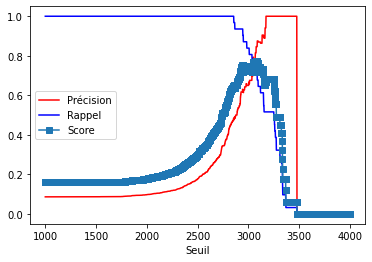

In [18]:



precisions = []
rappels = []
seuils = range(1000, 4000)
scores = []
for seuil in seuils:
    prediction = predict(testX, w, seuil)
    preci, rappel = performance(testY, prediction)
    precisions.append(preci)
    rappels.append(rappel)
    scores.append(score_harmonique(preci,rappel))

plt.plot(seuils, precisions,"r-", label="Précision")
plt.plot(seuils, rappels, "b-", label="Rappel")
plt.plot(seuils, scores, "s-", label="Score")
plt.legend()
plt.xlabel("Seuil")
plt.show()